In [18]:
from FNN import dataprocessing
from FNN import freezingmodel
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import pickle
%matplotlib inline

In [19]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


In [ ]:
with open("train_data.pkl", "rb") as f:
    X_train, X_test, y_train, y_test = pickle.load(f)
# X_train, X_test, y_train, y_test = train_test_split(kf_est.to_numpy(), freeze.to_numpy(), train_size=0.80)
ss = StandardScaler()

features = torch.tensor(ss.fit_transform(X_train), dtype=torch.float32).to(device)
labels = torch.tensor(y_train, dtype=torch.float32).to(device)

data = freezingmodel.dataset(X_train, y_train.reshape(-1))
data_loader = DataLoader(data, batch_size=1000, shuffle=True)

input_size = 54
# device = torch.device('cuda')
nn_model = freezingmodel.net(input_size).to(device)


criterion = nn.BCELoss()
optimizer = optim.SGD(nn_model.parameters(), lr=0.005)

num_epochs = 1000

for epoch in range(num_epochs):
    for batch_features, batch_labels in data_loader:
        batch_features = batch_features.unsqueeze(1).to(device)  # Add channel dimension
        batch_labels = batch_labels.unsqueeze(1).to(device)
        # Forward pass
        outputs = nn_model(batch_features)
        loss = criterion(outputs, batch_labels.unsqueeze(1))  # unsqueeze to match the shape

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Save the model every 100 epochs
        if epoch % 10 == 0:
            torch.save(nn_model.state_dict(), "freeze.pth")


        if epoch % 10 == 0:
            print("epoch = %4d   loss = %0.9f" % \
                  (epoch, loss))

epoch =    0   loss = 1.362028122
epoch =    0   loss = 4.183245182
epoch =    0   loss = 4.802201271
epoch =    0   loss = 5.453820229
epoch =    0   loss = 5.834920406
epoch =    0   loss = 6.491732597
epoch =    0   loss = 4.619793415
epoch =    0   loss = 5.444023132
epoch =    0   loss = 5.073428154
epoch =    0   loss = 4.766932964
epoch =    0   loss = 5.567922115
epoch =    0   loss = 6.070884228
epoch =    0   loss = 4.470135212
epoch =    0   loss = 4.968365192
epoch =    0   loss = 5.955698490
epoch =    0   loss = 5.441824913
epoch =    0   loss = 5.118685246
epoch =    0   loss = 5.859676361
epoch =    0   loss = 4.477181911
epoch =    0   loss = 5.477801800
epoch =    0   loss = 5.289179325
epoch =    0   loss = 5.116111755
epoch =    0   loss = 4.538929462
epoch =    0   loss = 5.328831196
epoch =    0   loss = 4.881735802
epoch =    0   loss = 5.818808079
epoch =    0   loss = 5.035189629
epoch =    0   loss = 5.498038292
epoch =    0   loss = 5.231278896
epoch =    0  

In [21]:
# Evaluation
nn_model.eval()  # Set the model to evaluation mode
total_correct = 0
total_samples = 0

features_test = torch.tensor(X_test, dtype=torch.float32).to(device)
labels_test = torch.tensor(y_test, dtype=torch.float32).to(device)

data_test = freezingmodel.dataset(X_test, y_test.reshape(-1))
data_loader_test = DataLoader(data_test, batch_size=10)  # no need to shuffle test data

with torch.no_grad():
    for batch_features, batch_labels in data_loader_test:
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)

        # Forward pass
        outputs = nn_model(batch_features)
        predicted_labels = torch.round(outputs)

        # Count correct predictions
        total_correct += (predicted_labels == batch_labels.unsqueeze(1)).sum().item()
        total_samples += batch_labels.size(0)

accuracy = total_correct / total_samples
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 93.12%


In [22]:
new_data = dataprocessing.dlcResults("/home/ryansenne/Downloads/Test_Video_m10_recall_120122-003DLC_resnet50_engram_round2_front_fcApr21shuffle1_400000.csv")
ss = StandardScaler()
df = new_data.filter_predictions(fps=30)

df = torch.tensor(ss.fit_transform(df.to_numpy()), dtype=torch.float32).to(device)


In [23]:
# n_model = freezingmodel.net(54).to(device)
# nn_model.load_state_dict(torch.load("freeze.pth"))
nn_model.eval()  # Sets the model to evaluation mode
# Forward pass through the model to get the predictions
with torch.no_grad():  # Disables gradient calculation to save memory
    predictions = nn_model(df)

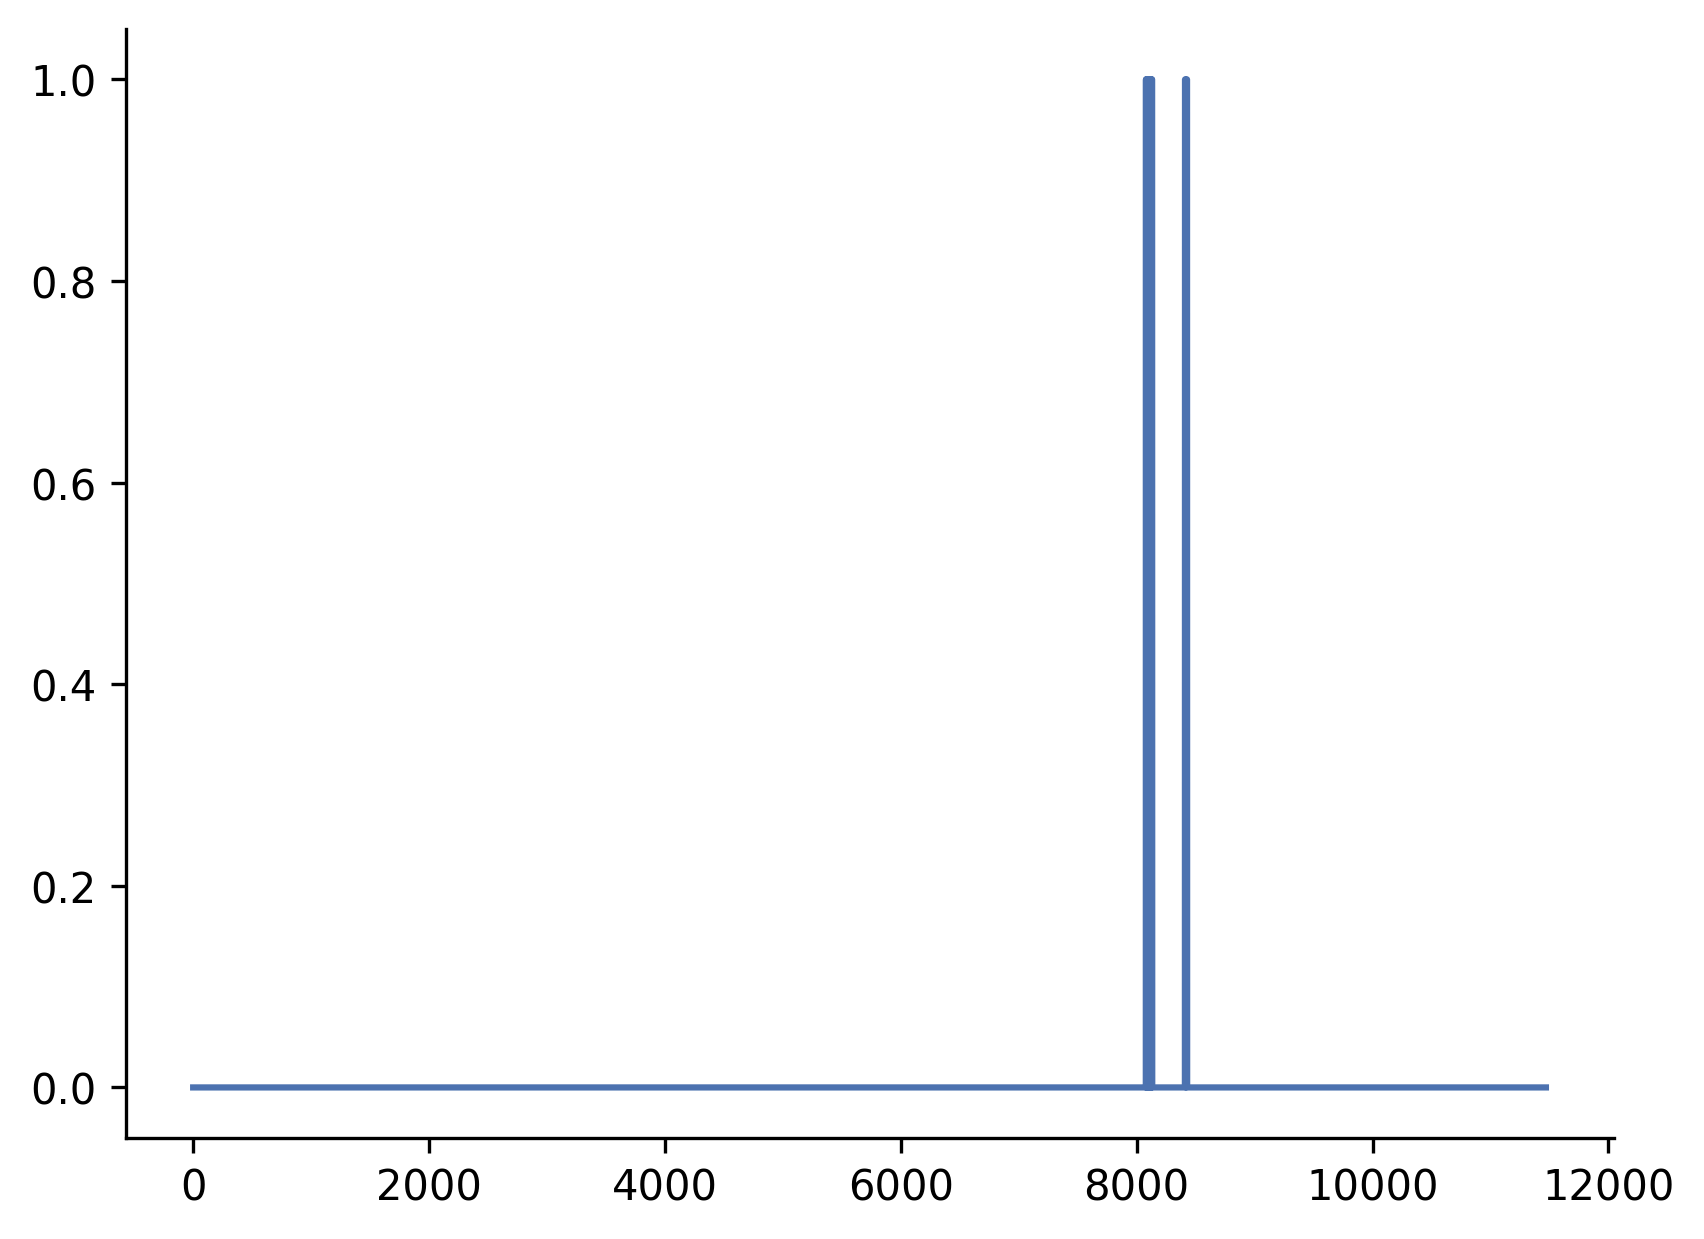

In [24]:
import matplotlib.pyplot as plt
plt.plot(torch.round(predictions.cpu()))